In [45]:
# -*- coding: utf-8 -*-
"""
ODYSSEA Virtual School 2020

@author: Lorinc Meszaros (Deltares)
"""
#Import packages
from netCDF4 import Dataset
import cftime as nc4
import os
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.io.img_tiles as cimgt
import matplotlib 
import matplotlib.pyplot as plt
import numpy.ma as ma
import warnings

In [46]:
#Dataset
dataset_chl1 = Dataset('sv03-med-ogs-pft-rean-m_1606317478723.nc') #chl

#Interrogate netCDF file
warnings.filterwarnings('ignore')
print (dataset_chl1.file_format)
print (dataset_chl1.dimensions.keys()) #dimensions
print (dataset_chl1.dimensions['time'])
print (dataset_chl1.variables.keys()) #variables
print (dataset_chl1.variables['time'])
print (dataset_chl1.Conventions) # Get conventions attribute

attr=dataset_chl1.ncattrs() #find all NetCDF global attributes  
for attr in dataset_chl1.ncattrs():
    print (attr, '=', getattr(dataset_chl1, attr))

NETCDF3_CLASSIC
dict_keys(['time', 'depth', 'latitude', 'longitude'])
<class 'netCDF4._netCDF4.Dimension'>: name = 'time', size = 107
dict_keys(['depth', 'chl', 'latitude', 'time', 'longitude'])
<class 'netCDF4._netCDF4.Variable'>
float64 time(time)
    units: seconds since 1970-01-01 00:00:00
    long_name: time
    standard_name: time
    axis: T
    calendar: standard
    _CoordinateAxisType: Time
    valid_min: 1264982400.0
    valid_max: 1543622400.0
unlimited dimensions: 
current shape = (107,)
filling on, default _FillValue of 9.969209968386869e+36 used
CF-1.0
Conventions = CF-1.0
references = Please check in CMEMS catalogue the INFO section for product MEDSEA_ANALYSIS_FORECAST_BIO_006_008 - http://marine.copernicus.eu/
institution = OGS (Istituto Nazionale di Oceanografia e di Geofisica Sperimentale) , Sgonico (Trieste) - Italy
source = 3DVAR-OGSTM-BFM
comment = Please check in CMEMS catalogue the INFO section for product MEDSEA_ANALYSIS_FORECAST_BIO_006_008 - http://marine.cop

In [47]:
#Access data
warnings.filterwarnings('ignore')
fh_chl1 = Dataset(nc_path_chl1, mode='r')
time1=fh_chl1.variables['time'] #access time
jd1 = nc4.num2date(time1[:],time1.units, only_use_cftime_datetimes=False, only_use_python_datetimes=True)
lons1 = fh_chl1.variables['longitude'][:] #access longitude
lats1 = fh_chl1.variables['latitude'][:] #access latitude
chl = np.squeeze(fh_chl1.variables['chl'][:]) #access chlorophyll
fh_chl1.close()

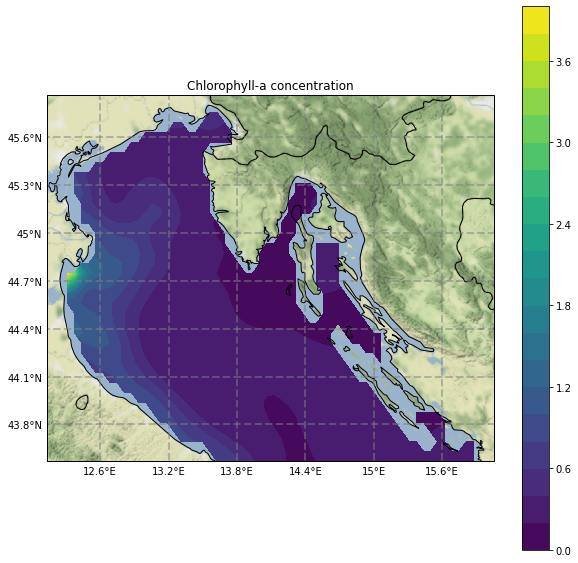

In [48]:
#PLOT map
timestep=1; #choose a time step (e.g. 0 - first image, 1 - second image, etc.)
chl_plot=np.squeeze(chl[timestep,:,:])

matplotlib.rcParams['figure.figsize'] = (10,10) #set figure size
proj=ccrs.Mercator() # Get some parameters for the Stereographic Projection
m = plt.axes(projection=proj)
# Put a background image on for nice sea rendering.
# Create a Stamen terrain background instance.
stamen_terrain = cimgt.Stamen('terrain-background')
m.add_image(stamen_terrain, 8)
#Add coastlines
m.coastlines(resolution='10m')
m.add_feature(cfeature.BORDERS.with_scale('10m'))
gl=m.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--') #add map gridlines
gl.xformatter = LONGITUDE_FORMATTER #format axis label
gl.yformatter = LATITUDE_FORMATTER #format axis label
gl.xlabels_top = False #disable axis label
gl.ylabels_right = False #disable axis label
#Plot data
plt.contourf(lons1, lats1, chl_plot, 20,
             transform=ccrs.PlateCarree(), vmin=0, vmax=4) #plot data

# Add Colorbar
cbar=plt.colorbar()             

# Add Title
plt.title('Chlorophyll-a concentration')
plt.show() #show plot

In [29]:
#Area average
av_area_chl = np.full([int(chl.shape[0])], np.nan)
yearly_av_chl= np.full([round(chl.shape[0]/12)], np.nan)
#Yearly average
av_area_chl = np.mean(np.mean(np.squeeze(chl[:,:,:]), axis = 1), axis=1)   
for i in np.arange(round(chl.shape[0]/12)):
    yearly_av_chl[i] = np.mean(av_area_chl[i:(i+12)])
start_year=int(str(jd1[0])[:4])

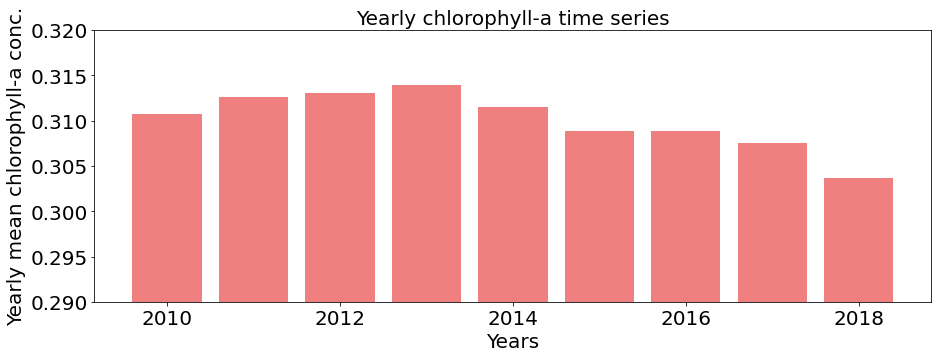

In [30]:
#Plot
fontsize=20
colors= ['lightcoral','plum','g','b',]

plt.figure(figsize=(15,5))
plt.bar(2010+np.arange(len(yearly_av_chl[:])), yearly_av_chl[:], color=colors[0])
plt.xlabel("Years", fontsize=fontsize)
plt.ylabel("Yearly mean chlorophyll-a conc.", fontsize=fontsize)
plt.title("Yearly chlorophyll-a time series", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylim(0.29,0.32)
plt.show()

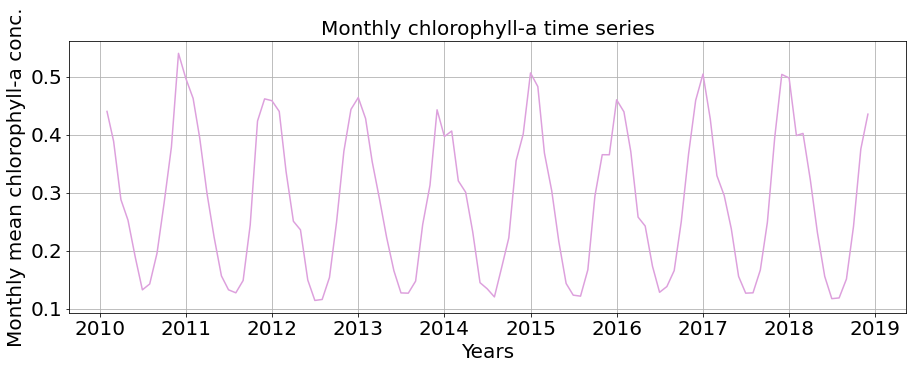

In [31]:
#Plot
plt.figure(figsize=(15,5))
plt.plot_date(jd1,av_area_chl, xdate=True, fmt='-', color=colors[1])
plt.grid()
plt.xlabel("Years", fontsize=fontsize)
plt.ylabel("Monthly mean chlorophyll-a conc.", fontsize=fontsize)
plt.title("Monthly chlorophyll-a time series", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.show()

In [38]:
#Trend lines
#Get linear regression slope at every segment of the map
#Np.polyfit - Chlorophyll
slope_chl = np.full([int(chl.shape[1]), int(chl.shape[2])], np.nan)
for j in range(0,int(chl.shape[1])):
    for i in range(0,int(chl.shape[2])):
        y=chl[:,j,i]
        X=np.arange(len(y))
        
        reg = np.polyfit(X, y, 2)
        slope_chl[j,i]=reg[1]
    print(str(round(j/chl.shape[1]*100/10)*10) + ' %')
        
slope_chl=ma.masked_invalid(slope_chl)
slope_chl=ma.masked_less(slope_chl, -100.0)

0 %
0 %
10 %
10 %
10 %
10 %
20 %
20 %
20 %
20 %
30 %
30 %
30 %
30 %
40 %
40 %
40 %
40 %
50 %
50 %
50 %
50 %
60 %
60 %
60 %
60 %
70 %
70 %
70 %
70 %
80 %
80 %
80 %
80 %
90 %
90 %
90 %
90 %
100 %


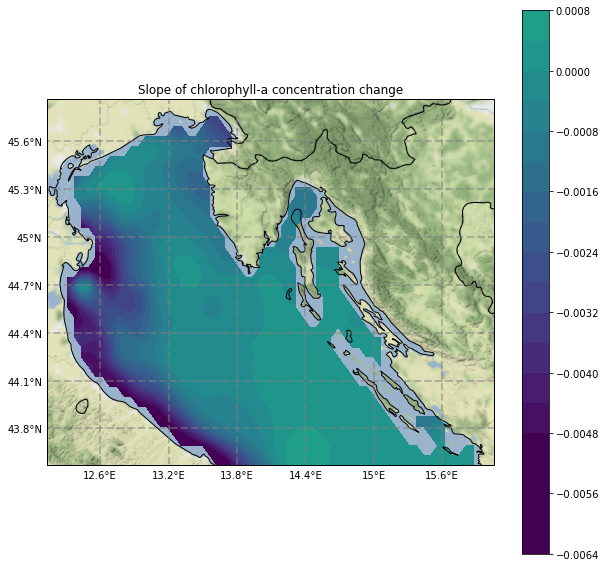

In [39]:
#PLOT SLOPE

matplotlib.rcParams['figure.figsize'] = (10,10) 
# Get some parameters for the Stereographic Projection
proj=ccrs.Mercator()
m = plt.axes(projection=proj)
# Put a background image on for nice sea rendering.
# Create a Stamen terrain background instance.
stamen_terrain = cimgt.Stamen('terrain-background')
m.add_image(stamen_terrain, 8)
#Add coastlines
m.coastlines(resolution='10m')
m.add_feature(cfeature.BORDERS.with_scale('10m'))
gl=m.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = False
gl.ylabels_right = False
#Plot data
plt.contourf(lons1, lats1, slope_chl, 20, vmin=-0.005, vmax=0.005,transform=ccrs.PlateCarree())

# Add Colorbar
plt.colorbar()

# Add Title
plt.title('Slope of chlorophyll-a concentration change')

plt.show()